## 1D bar, FEM

In [25]:
#Load packages
from scipy.sparse import coo_matrix, csr_matrix   #for sparse matrix
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve


Define element routines, linear elements

$$N_1(x)=1-x/L=1-\xi, \quad N_2(x)=x/L=\xi$$
and matrix
$$
\mathbf{N}=[N_1 \quad N_2]
$$

In [26]:
xi = sp.symbols('xi',real='true')
N1 = 1-xi; N2=xi
Ne=sp.Matrix([N1,N2])
#produce function in Python
Ne_func=sp.lambdify([xi],Ne )
print(Ne)

Matrix([[1 - xi], [xi]])


Coordinate 
$x=N_1(\xi) \, x_1^e+N_2(\xi) \, x_2^e$ whereby $dx/d\xi $ becomes

In [27]:
#introduce node positions via Ex
Ex  = Ex1,Ex2 = sp.symbols('Ex1 Ex2',real='true')
xe1=Ex1 #left node position of element
xe2=Ex2 #right node position of element
x=N1*xe1+N2*xe2
dx_dxi=sp.diff(x,xi)
dx_dxi_func=sp.lambdify([Ex],dx_dxi )
print(dx_dxi)

-Ex1 + Ex2


Compute derivatives of base functions $dN_1/dx$ and $dN_2/dx$ and define matrix $\mathbf{B}=\left[dN_1/dx \quad dN_2/dx \right]$:

In [28]:
dN1_dx=1/dx_dxi*sp.diff(N1,xi);
dN2_dx=1/dx_dxi* sp.diff(N2,xi)  
#define element B-matrix
Be=sp.Matrix([dN1_dx, dN2_dx])
#create function and save it 
Be_func=sp.lambdify([xi,Ex],Be )
print(Be)

Matrix([[-1/(-Ex1 + Ex2)], [1/(-Ex1 + Ex2)]])


Finite element problem of bar with clamped boundaries, solve $u(x)=\mathbf{N} \, \mathbf a$:

$$
 \int_0^L  \mathbf{B}^T \, \mathbf{B} \,  dx \, \mathbf a
 =\int_0^L \mathbf{N}^T \, \frac{K_x}{E} \, dx
$$
With
$$
\mathbf{K}=\int_0^L  \mathbf{B}^T \, \mathbf{B} \,  dx,  \quad
\mathbf{f}=\int_0^L \int_0^L \mathbf{N}^T \, \frac{K_x}{E} \, dx
$$
We obtain the nodal displacements $\mathbf a$ from:
$$
\mathbf{K}  \, \mathbf a=\mathbf f
$$
Here we assume mid-point rule for spatial integration such that
$$
\mathbf{K}=  \mathbf{B}^T(\xi=1/2)  \, \mathbf{B}(\xi=1/2)  \,  \Delta x, \quad
\mathbf{f}=\mathbf{N}^T(\xi=1/2)  \, \frac{K_x}{E}  \, \Delta x
$$
Here follows an element routine for these quantities.


In [29]:
def element1d_K(Ex):
    xi=1./2
    Be=Be_func(xi,Ex)
    dx_dxi=dx_dxi_func(Ex)
    dx=(Ex[1]-Ex[0])
    Ke=(Be.T*Be)*dx_dxi
    return Ke
def element1d_f(Ex,Kx,Emod):
    xi=1./2
    Ne=Ne_func(xi)
    dx_dxi=dx_dxi_func(Ex)
    dx=(Ex[1]-Ex[0])
    fe_ext=Ne.T*Kx/Emod*dx_dxi
    return (fe_ext)


Assume the following numerical values and define a spatial mesh

In [30]:
L=1000 #length of body mm
Emod=200.e3 #N/mm^2
Kx=100. #=N/mm^3 
nel=100; #number of elements

In [31]:
ndofs=round(nel+1) #number of dof (number of node displacements)
Ex=np.linspace(0,L,ndofs) #discretization
dx=Ex[1]-Ex[0]
Edof=np.zeros((nel,2),'int')
for i in range(nel):
    Edof[i,0]=i+1
    Edof[i,1]=i+2


In [32]:
#test element routines
Ke=element1d_K(np.array([Ex[0],Ex[1]]))
fe_ext=element1d_f(np.array([Ex[0],Ex[1]]),Kx,Emod)
print(f'Ke= {Ke}')
print(f'fe_ext= {fe_ext}')


Ke= [[ 0.1 -0.1]
 [-0.1  0.1]]
fe_ext= [[0.0025 0.0025]]


Define time history

In [33]:
tend=1000
ntime=100
# time history    
tt = np.linspace(0, tend, ntime)
dt=tt[1]-tt[0] #assume constant time step

Define a body load function

In [34]:
def body_moving_load_vector(body, body_width, velocity, time, xpos):
    current_load_center = velocity * time
    body_out = np.zeros_like(xpos)  # Initialize body_out with zeros of the same size as xpos

    # Apply the condition element-wise, in this range the body load takes the value "body"
    in_range = (xpos >= (current_load_center - body_width / 2)) & (xpos <= (current_load_center + body_width / 2))
    body_out[in_range] = body

    return body_out

def hertz_distribution(x, a, Kx0, velocity, time):
    """
    Computes the Hertz Kx distribution 
    
    Parameters:
    - x: grid points (x coordinates).
    - a: Load radius (half-width of the load length).
    - Kx0: Maximum Kx at the center.
    
    Returns:
    - Kx_values: Kx values at each x  point.
    """
    x0=velocity*time
    # Compute the radius from the center
    r = np.sqrt((x-x0)**2) 
    
    # Pressure distribution (Hertz formula)
    Kx_distribution = np.where(r <= a, Kx0 * np.sqrt(np.abs(1.0001 - (r / a)**2)), 0)
    
    return Kx_distribution

def tent_distribution(x, a, Kx0, velocity, time):
    """
    Computes the tent-like Kx distribution 
    
    Parameters:
    - x: grid points (x coordinates).
    - a: Load radius (half-width of the load length).
    - Kx0: Maximum Kx at the center.
    
    Returns:
    - Kx_values: Kx values at each x  point.
    """
    x0=velocity*time
    # Compute the radius from the center
    r = np.sqrt((x-x0)**2) 
    
    # Pressure distribution (Hertz formula)
    Kx_distribution = np.where(r <= a, Kx0 * (1 - r / a), 0)
    
    return Kx_distribution



Data for body load, and graphical illustration

Text(0.5, 1.0, 'body load distribution at half-time')

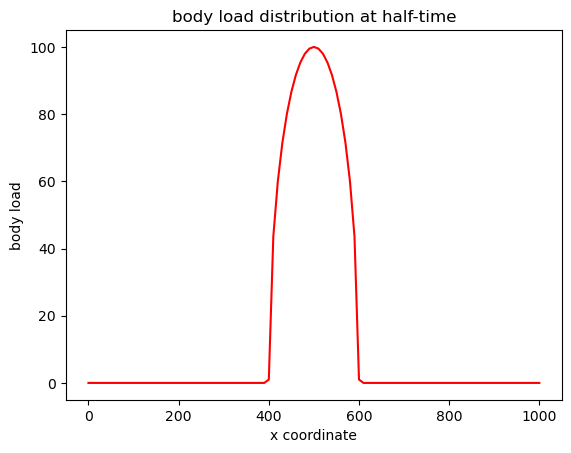

In [35]:
###
body_width=L/10 #assume portion of the total length
velocity=L/tend #assume that the load travels the full length

#plot a figure how the temperature load looks like at half-time
body_plot=hertz_distribution(Ex, body_width, Kx, velocity, tend/2)  
plt.plot(Ex,body_plot, 'r', label='intial temperature field')
plt.xlabel('x coordinate')
plt.ylabel('body load')
plt.title('body load distribution at half-time')

Routines for assembling

In [36]:
#routine that only computes K
def assembling_my_1d_K(ndofs,nel,Edof,Ex):
    # assemble matrices
    #K = np.zeros((ndofs, ndofs))
    K = lil_matrix((ndofs, ndofs))
    # Loop through each element
    for el in range(nel):
        dof_indices = Edof[el, :]-1  # Extract the degrees of freedom indices (all columns in the el-th row)
        Ke= element1d_K(Ex[dof_indices])
        K[np.ix_(dof_indices, dof_indices)] += Ke
    # Sparse  -> spsolveq
    Ks = K.tocsr() #csr_matrix(K, shape=(ndofs, ndofs))
    return Ks
#routine that only computes f
def assembling_my_1d_f(ndofs,nel,Edof,Ex,body,body_width,velocity,time,Emod):
    # assemble matrices
    f = np.zeros((ndofs, 1))
    # Loop through each element
    for el in range(nel):
        dof_indices = Edof[el, :]-1  # Extract the degrees of freedom indices (all columns in the el-th row)
        xpos=(Ex[dof_indices[0]]+Ex[dof_indices[1]])/2.
        body_out=hertz_distribution(xpos, body_width, body, velocity, time)  #body_moving_load_vector(body,body_width,velocity,time,xpos)
        fe_ext= element1d_f(Ex[dof_indices],body_out,Emod)
        f[np.ix_(dof_indices)] += fe_ext.T
    return f

Create global stiffness matrix

In [37]:


a_hist=np.zeros((ndofs,ntime+1))
#a_n = a_hist[:, 0] #.reshape(-1,1)  #assume zero initial conditions
Ks=assembling_my_1d_K(ndofs,nel,Edof,Ex)


Routine for partitioning the dof that are prescribed and unknown

In [38]:

dof_prescribed=[0] #for prescribed end values
dof_values=[0.]  #the prescribed value

def dof_partitioning(dof_prescribed,ndofs):
    dof_f = np.ones(ndofs, dtype=bool)
    dof_f[dof_prescribed] = False
    dof_r = np.zeros(ndofs, dtype=bool)
    dof_f[dof_prescribed] = False
    dof_r[dof_prescribed] = True
    return  dof_f, dof_r

def sparse_matrix_partitioning(dof_f,dof_r,Ks):
    return Ks[dof_f][:, dof_f],Ks[dof_f][:, dof_r],Ks[dof_r][:, dof_f], Ks[dof_r][:, dof_r] 


In [39]:
#(Kff*uf+Kfr*ur)=ff -> uf=inv(Kff)*(ff-Kfr*ur)
#(Krf*uf+Krr*ur)=fr
# Divide Ks and Ms in ff,fr,rf,rr parts 
dof_f, dof_r= dof_partitioning(dof_prescribed,ndofs)
Ks_ff,Ks_fr,Ks_rf,Ks_rr=sparse_matrix_partitioning(dof_f,dof_r,Ks)

Here comes the time loop for solving the problem ineach timestep (since load is changing its position)


In [40]:

a=np.zeros(ndofs)

for i in range(ntime):
    f=assembling_my_1d_f(ndofs,nel,Edof,Ex,Kx,body_width,velocity,tt[i],Emod)
    f_f = f[dof_f]         
    a_f=spsolve(Ks_ff,f_f[:,0] )
    a[dof_f]=a_f
    a_hist[:,i]=a #save in history matrix

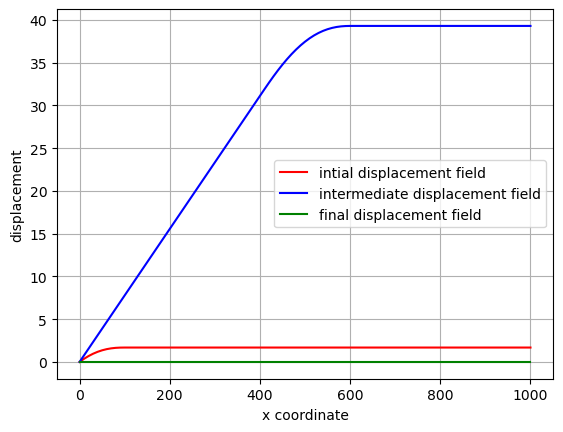

In [41]:
#
plt.plot(Ex,a_hist[:,0], 'r', label='intial displacement field')
plt.plot(Ex,a_hist[:,round(ntime/2)], 'b', label='intermediate displacement field')
plt.plot(Ex,a_hist[:,-1], 'g', label='final displacement field')
plt.xlabel('x coordinate')
plt.ylabel('displacement')
plt.grid()
plt.legend()



Use the results as snapshots and perform SVD

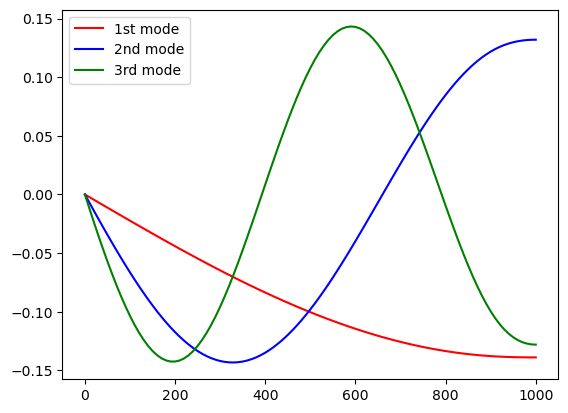

In [42]:
#save snapshots
# Economy SVD of a_hist
X=a_hist
time_hist = np.linspace(0, tend, ntime)
Uec, Sec, VTec = np.linalg.svd(X, full_matrices=False)

plt.plot(Ex,Uec[:,0], 'r', label='1st mode')
plt.plot(Ex,Uec[:,1], 'b', label='2nd mode')
plt.plot(Ex,Uec[:,2], 'g', label='3rd mode')
plt.legend()
    

Now adopt the $n_r$ spatial modes $\Phi$ from the columns of $U$.

In [43]:
nr=5
Phi=np.zeros((ndofs,nr))
for i in range(nr):
    Phi[:,i]=Uec[:,i]


In [44]:
b_hist=np.zeros((nr,ntime+1))
b_n = b_hist[:, 0] #.reshape(-1,1)  #assume zero initial conditions

#Ks=assembling_my_1d_K_red(ndofs,nel,Edof,Ex,Phi)
K_not_sparse=Ks.toarray()
K_red=Phi.T @ K_not_sparse @ Phi


for i in range(ntime):
    f=assembling_my_1d_f(ndofs,nel,Edof,Ex,Kx,body_width,velocity,tt[i],Emod)
    f_red=Phi.T  @ f
    b = np.linalg.solve(K_red, f_red[:,0])
    b_n=b
    b_hist[:,i]=b #save in history matrix

a_hist_red=np.zeros((ndofs,ntime+1))
for i in range(ntime+1):
    a_hist_red[:,i]=Phi @ b_hist[:,i]


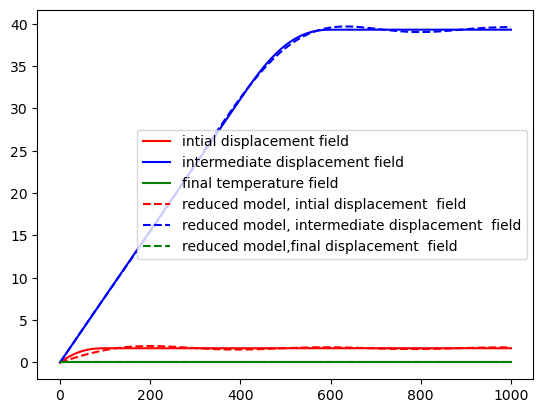

In [45]:
plt.plot(Ex,a_hist[:,0], 'r', label='intial displacement field')
plt.plot(Ex,a_hist[:,round(ntime/2)], 'b', label='intermediate displacement field')
plt.plot(Ex,a_hist[:,-1], 'g', label='final temperature field')


plt.plot(Ex,a_hist_red[:,0], 'r--', label='reduced model, intial displacement  field')
plt.plot(Ex,a_hist_red[:,round(ntime/2)], 'b--', label='reduced model, intermediate displacement  field')
plt.plot(Ex,a_hist_red[:,-1], 'g--', label='reduced model,final displacement  field')



plt.legend()